### Importar librerias y el archivo csv 

In [9]:
import pandas as pd # Para manejo de datos y dataframes
import geopandas as gpd # Para manejo de datos geoespaciales 
import matplotlib.pyplot as plt # Para graficar datos
import seaborn as sns # Para graficar datos
import folium # Para visualizar mapas
from folium.plugins import HeatMap # Para visualizar mapas de calor
from shapely.geometry import Point # Para trabajar con puntos y geometrías
import numpy as np # Para operaciones matemáticas



# Cargar datos
reportes_df = pd.read_csv('reportes_agua_hist.csv')
colonias_gdf = gpd.read_file('catlogo-de-colonias.json')
alcaldias_gdf = gpd.read_file('limite-de-las-alcaldas.json')


### Limpiar el dataset con los atributos innecesarios, datos NaN y seleccionando el año 2021

In [3]:
# Filtrar reportes para el año 2021
reportes_df['fecha'] = pd.to_datetime(reportes_df['fecha'])
reportes_2021 = reportes_df[reportes_df['fecha'].dt.year == 2021]
#eliminar los valores NaN
reportes_2021 = reportes_2021.dropna()



### Encontrar el tipo de falla mas recurrente, la alcaldia y la colonia con mas reportes

In [4]:
# Identificar tipo de falla más recurrente
tipo_falla_mas_recurrente = reportes_2021['tipo_de_falla'].value_counts().idxmax()

# Determinar alcaldía con más reportes
alcaldia_con_mas_reportes = reportes_2021['alcaldia'].value_counts().idxmax()
reportes_alcaldia = reportes_2021[reportes_2021['alcaldia'] == alcaldia_con_mas_reportes]



In [5]:


# Inicializar la columna de 'colonia_datos_abiertos' en el dataframe original
reportes_alcaldia['colonia_datos_abiertos'] = None
reportes_alcaldia = reportes_alcaldia.drop(columns=['colonia_datos_abiertos'])

# Seleccionar solo los reportes de fugas de agua
reportes_fugas = reportes_alcaldia[reportes_alcaldia['tipo_de_falla'] == 'Falta de agua']

# Crear geometrías de puntos para los reportes de fugas
reportes_fugas['geometry'] = [Point(xy) for xy in zip(reportes_fugas['longitud'], reportes_fugas['latitud'])]

# Convertir el DataFrame en un GeoDataFrame
reportes_fugas_gdf = gpd.GeoDataFrame(reportes_fugas, crs=colonias_gdf.crs)

# Asegurarse de que ambos GeoDataFrames están en el mismo sistema de referencia de coordenadas (CRS)
reportes_fugas_gdf = reportes_fugas_gdf.to_crs(colonias_gdf.crs)

# Realizar una unión espacial para asignar colonias a los reportes de fugas
reportes_alcaldia = gpd.sjoin(reportes_fugas_gdf, colonias_gdf, how='left', predicate='within')

# Renombrar la columna para reflejar los datos
reportes_alcaldia = reportes_alcaldia.rename(columns={'colonia': 'colonia_datos_abiertos'})

# Eliminar la columna de índice creada por el sjoin si existe
reportes_alcaldia = reportes_alcaldia.drop(columns=['index_right'], errors='ignore')



reportes_alcaldia


C:\Users\aleke\AppData\Local\Temp\ipykernel_18220\2655219574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reportes_alcaldia['colonia_datos_abiertos'] = None
C:\Users\aleke\AppData\Local\Temp\ipykernel_18220\2655219574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reportes_fugas['geometry'] = [Point(xy) for xy in zip(reportes_fugas['longitud'], reportes_fugas['latitud'])]


folio  tipo_de_falla  quien_atiende    latitud   longitud  \
478     20210525-0198  Falta de agua  Sur Xotepingo  19.302233 -99.117201   
525     20210521-0017  Falta de agua  Sur Xotepingo  19.306483 -99.104603   
538     20210523-0081  Falta de agua  Sur Xotepingo  19.321549 -99.160837   
540     20210523-0141  Falta de agua  Sur Xotepingo  19.306326 -99.137077   
603     20210529-0067  Falta de agua  Sur Xotepingo  19.306354 -99.194159   
...               ...            ...            ...        ...        ...   
251941  20210423-0011  Falta de agua  Sur Xotepingo  19.318489 -99.164571   
251942  20210424-0054  Falta de agua  Sur Xotepingo  19.320249 -99.156161   
251950  20210425-0148  Falta de agua  Sur Xotepingo  19.344968 -99.141810   
251954  20210423-0101  Falta de agua  Sur Xotepingo  19.339592 -99.169780   
252071  20211018-0186  Falta de agua  Sur Xotepingo  19.322412 -99.158111   

        codigo_postal      fecha                      colonia_registro_sacmex  \
478            4940.0 2021-05-25                                        Coapa   
525            4930.0 2021-05-21                                    Cafetales   
538            4300.0 2021-05-23                             Ciudad de México   
540            4980.0 2021-05-23  El Vergel de Coyoacán ( Infonavit El Hueso)   
603            4500.0 2021-05-29           Jardines del Pedregal de San Ángel   
...               ...        ...                                          ...   
251941         4300.0 2021-04-23                                       Ajusco   
251942         4300.0 2021-04-24                                       Ajusco   
251950         4220.0 2021-04-25                      Country Club Churubusco   
251954         4320.0 2021-04-23                    Pedregal de San Francisco   
252071         4300.0 2021-10-18                             Ciudad de México   

        alcaldia                    geometry cve_ent           entidad  \
478     COYOACAN  POINT (-99.11720 19.30223)      09  Ciudad de México   
525     COYOACAN  POINT (-99.10460 19.30648)      09  Ciudad de México   
538     COYOACAN  POINT (-99.16084 19.32155)      09  Ciudad de México   
540     COYOACAN  POINT (-99.13708 19.30633)      09  Ciudad de México   
603     COYOACAN  POINT (-99.19416 19.30635)      09  Ciudad de México   
...          ...                         ...     ...               ...   
251941  COYOACAN  POINT (-99.16457 19.31849)      09  Ciudad de México   
251942  COYOACAN  POINT (-99.15616 19.32025)      09  Ciudad de México   
251950  COYOACAN  POINT (-99.14181 19.34497)      09  Ciudad de México   
251954  COYOACAN  POINT (-99.16978 19.33959)      09  Ciudad de México   
252071  COYOACAN  POINT (-99.15811 19.32241)      09  Ciudad de México   

       cve_alc       alc  cve_col              colonia_datos_abiertos   clasif  
478        003  Coyoacán  003-068                          Los Sauces  Colonia  
525        003  Coyoacán  003-012                           Cafetales  Colonia  
538        003  Coyoacán  003-002                              Ajusco  Colonia  
540        003  Coyoacán  003-095      Viejo Ejido Santa Ursula Coapa  Colonia  
603        003  Coyoacán  003-060  Jardines Del Pedregal De San Angel  Colonia  
...        ...       ...      ...                                 ...      ...  
251941     003  Coyoacán  003-002                              Ajusco  Colonia  
251942     003  Coyoacán  003-002                              Ajusco  Colonia  
251950     003  Coyoacán  003-013                Campestre Churubusco  Colonia  
251954     003  Coyoacán  003-076            Pedregal De Sn Francisco  Colonia  
252071     003  Coyoacán  003-002                              Ajusco  Colonia  

[7478 rows x 17 columns]

In [6]:
# Agrupar reportes por colonia dentro de la alcaldía identificada
colonia_con_mas_reportes = reportes_alcaldia['colonia_datos_abiertos'].value_counts().idxmax()

print(f'Tipo de falla más recurrente: {tipo_falla_mas_recurrente}')
print(f'Alcaldía con más reportes: {alcaldia_con_mas_reportes}')
print(f'Colonia con más reportes: {colonia_con_mas_reportes}')

Tipo de falla más recurrente: Falta de agua
Alcaldía con más reportes: COYOACAN
Colonia con más reportes: Pedregal De Santo Domingo


### Preparar los datos para la graficacion de un mapa dinamico
 1. hacer un conteo de reportes de falta de agua por alcaldia dependiendo la ubicacion geografica (Latitud, Longitud) del csv "reportes_agua_hist.csv" y agregarlo a al Json "limite-de-las-alcaldas.json"



In [7]:
# Crear un diccionario para almacenar el conteo de reportes por fala de agua por alcaldía
conteo_por_alcaldia = {alcaldia: 0 for alcaldia in alcaldias_gdf['NOMGEO']}
# Calcular el conteo de reportes de falta de agua por alcaldía
for idx, row in reportes_2021.iterrows():  # Iterar sobre cada reporte
    for idx, alc_row in alcaldias_gdf.iterrows():  # Iterar sobre cada alcaldía
        if alc_row['geometry'].contains(Point(row['longitud'], row['latitud'])):  # Verificar si el reporte está dentro de la alcaldía
            conteo_por_alcaldia[alc_row['NOMGEO']] += 1  # Incrementar el conteo de reportes de la alcaldía
            break

#agregar la columna de conteo al GeoDataFrame de alcaldías
alcaldias_gdf['conteo'] = alcaldias_gdf['NOMGEO'].str.upper().map(reportes_2021['alcaldia'].value_counts())

 2. hacer un conteo de reportes de falta de agua por colonia dependiendo la ubicacion geografica (Latitud, Longitud) del csv "reportes_agua_hist.csv" y agregarlo al Json "catlogo-de-colonias.json"

In [8]:
# Crear un diccionario para almacenar el conteo de reportes por colonia
conteo_por_colonia = {colonia: 0 for colonia in colonias_gdf['colonia']}

# Calcular el conteo de reportes de falta de agua por colonia
for idx, row in reportes_alcaldia.iterrows():  # Iterar sobre cada reporte
    for idx, col_row in colonias_gdf.iterrows():  # Iterar sobre cada colonia
        if col_row['geometry'].contains(Point(row['longitud'], row['latitud'])):  # Verificar si el reporte está dentro de la colonia
            conteo_por_colonia[col_row['colonia']] += 1  # Incrementar el conteo de reportes de la colonia
            break

#agregar la columna de conteo al GeoDataFrame de colonias
colonias_gdf['conteo'] = colonias_gdf['colonia'].map(conteo_por_colonia)


### Mapa interactivo

In [19]:
# Crear el mapa
mapa = folium.Map(location=[19.432608, -99.133209], zoom_start=11)

# Añadir las divisiones políticas al mapa
alcaldias_layer = folium.GeoJson(
    alcaldias_gdf,
    name='Alcaldías de CDMX',
    style_function=lambda x: {
        'fillColor': '#1414b8',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2,
        # Cambiar el color de la alcaldía con más reportes
        'fillColor': '#ff0000' if x['properties']['NOMGEO'] == 'Coyoacan' else '#1414b8'
    },
    #tooltip=folium.features.GeoJsonTooltip(fields=['NOMGEO'], aliases=['Alcaldía:']),
    tooltip=folium.features.GeoJsonTooltip(fields=['NOMGEO', 'conteo'], aliases=['Alcaldia:', 'Reportes:']),

     highlight_function=lambda x: {
        'weight': 5,
        'fillOpacity': 0.5,
        'color': '#ff0000' if x['properties']['NOMGEO'] == "Coyoacan" else '#1414b8'
    }
)
alcaldias_layer.add_to(mapa)


# Crear el mapa de calor de todo CDMX
heat_data_2021 = [[row['latitud'], row['longitud']] for index, row in reportes_2021.iterrows()]
heat_layer_2021 = HeatMap(heat_data_2021, radius=15, name='Mapa de Calor de CDMX')
heat_layer_2021.add_to(mapa)

# Crear el mapa de calor específico de una alcaldía
heat_data_alcaldia = [[row['latitud'], row['longitud']] for index, row in reportes_alcaldia.iterrows()]
heat_layer_alcaldia = HeatMap(heat_data_alcaldia, radius=15, name='Mapa de Calor de la Alcaldía con más reportes')


# Filtrar y agregar divisiones de colonias de Coyoacán
colonias_gdf = colonias_gdf[colonias_gdf['alc'] == 'Coyoacán']

alcaldias_layer = folium.GeoJson(
    colonias_gdf,
    name='Alcaldía con más reportes',
    style_function=lambda x: {
        'fillColor': '#1414b8',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2,
        # Cambiar el color de la colonia con más reportes
        'fillColor': '#ff0000' if x['properties']['colonia'] == colonia_con_mas_reportes else '#1414b8'
    },
    #agregar el nombre de la colonia Y EL CONTEO DE REPORTES DE FALTA DE AGUA como tooltip
    tooltip=folium.features.GeoJsonTooltip(fields=['colonia', 'conteo'], aliases=['Colonia:', 'Reportes:']),
    #resaltar la colonia con más reportes de color rojo
    highlight_function=lambda x: {
        'weight': 5,
        'fillOpacity': 0.5,
        'color': '#ff0000' if x['properties']['colonia'] == colonia_con_mas_reportes else '#1414b8'
    }
)
alcaldias_layer.add_to(mapa)


# Añadir capas restantes al control de capas, pero no al mapa inicial
heat_layer_alcaldia.add_to(mapa)


# JavaScript personalizado
custom_js = """
<script>
    // Esperar a que el DOM se cargue completamente antes de modificar el control de capas
    window.addEventListener('DOMContentLoaded', (event) => {
        // Seleccionar el control de capas
        var layerControl = document.querySelector('.leaflet-control-layers-overlays');

        // Obtener todas las capas
        var layers = layerControl.querySelectorAll('input');

        // Desmarcar todas las capas
        layers.forEach(layer => layer.checked = false);

        // Marcar las primeras dos capas
        if (layers.length > 0) layers[0].checked = true;
        if (layers.length > 1) layers[1].checked = true;

        // Trigger the change event for the layers to apply the changes
        layers[0].dispatchEvent(new Event('change'));
        layers[1].dispatchEvent(new Event('change'));
    });
</script>
"""


# Agregar el JavaScript personalizado al mapa
mapa.get_root().html.add_child(folium.Element(custom_js))

# Añadir el control de capas
folium.LayerControl(collapsed=False).add_to(mapa)

# Mostrar el mapa
mapa.save('mapa.html' )
mapa


In [34]:
import folium
from folium.plugins import HeatMap

# Crear el mapa
mapa = folium.Map(location=[19.342564, -99.143763], zoom_start=10)

# Añadir las divisiones políticas al mapa
alcaldias_layer = folium.GeoJson(
    alcaldias_gdf,
    name='Alcaldías de CDMX',
    style_function=lambda x: {
        'fillColor': '#1414b8',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2,
        'fillColor': '#ff0000' if x['properties']['NOMGEO'] == 'Coyoacan' else '#1414b8'
    },
    tooltip=folium.features.GeoJsonTooltip(fields=['NOMGEO', 'conteo'], aliases=['Alcaldia:', 'Reportes:']),
    highlight_function=lambda x: {
        'weight': 5,
        'fillOpacity': 0.5,
        'color': '#ff0000' if x['properties']['NOMGEO'] == "Coyoacan" else '#1414b8'
    }
)
alcaldias_layer.add_to(mapa)

# Crear el mapa de calor de todo CDMX
heat_data_2021 = [[row['latitud'], row['longitud']] for index, row in reportes_2021.iterrows()]
heat_layer_2021 = HeatMap(heat_data_2021, radius=15, name='Mapa de Calor de CDMX')
heat_layer_2021.add_to(mapa)

# Crear el mapa de calor específico de una alcaldía
heat_data_alcaldia = [[row['latitud'], row['longitud']] for index, row in reportes_alcaldia.iterrows()]
heat_layer_alcaldia = HeatMap(heat_data_alcaldia, radius=15, name='Mapa de Calor de la Alcaldía con más reportes')

# Filtrar y agregar divisiones de colonias de Coyoacán
colonias_gdf = colonias_gdf[colonias_gdf['alc'] == 'Coyoacán']

colonias_layer = folium.GeoJson(
    colonias_gdf,
    name='Colonias en Coyoacán',
    style_function=lambda x: {
        'fillColor': '#1414b8',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2,
        'fillColor': '#ff0000' if x['properties']['colonia'] == colonia_con_mas_reportes else '#1414b8'
    },
    tooltip=folium.features.GeoJsonTooltip(fields=['colonia', 'conteo'], aliases=['Colonia:', 'Reportes:']),
    highlight_function=lambda x: {
        'weight': 5,
        'fillOpacity': 0.5,
        'color': '#ff0000' if x['properties']['colonia'] == colonia_con_mas_reportes else '#1414b8'
    }
)
colonias_layer.add_to(mapa)

# Añadir capas restantes al control de capas, pero no al mapa inicial
heat_layer_alcaldia.add_to(mapa)

# JavaScript personalizado
custom_js = """
<script>
    window.addEventListener('DOMContentLoaded', (event) => {
        var layerControl = document.querySelector('.leaflet-control-layers-overlays');
        var layers = layerControl.querySelectorAll('input');
        layers.forEach(layer => layer.checked = false);
        if (layers.length > 0) layers[0].checked = true;
        if (layers.length > 1) layers[1].checked = true;
        layers[0].dispatchEvent(new Event('change'));
        layers[1].dispatchEvent(new Event('change'));
    });
</script>
"""

# CSS personalizado para prevenir el modo oscuro
custom_css = """
<style>
    body {
        background-color: white !important;
        color: black !important;
    }
    .leaflet-container {
        background: white !important;
    }
    .leaflet-control-layers {
        background-color: white !important;
        color: black !important;
    }
    .leaflet-popup-content-wrapper, .leaflet-popup-tip {
        background: white !important;
        color: black !important;
    }
    .leaflet-bar a, .leaflet-bar a:hover {
        background-color: white !important;
        color: black !important;
    }
    .leaflet-control-zoom-in, .leaflet-control-zoom-out {
        background-color: white !important;
        color: black !important;
    }
    .leaflet-control-layers-selector {
        background-color: white !important;
        color: black !important;
    }
</style>
"""

# Agregar el JavaScript y CSS personalizado al mapa
mapa.get_root().html.add_child(folium.Element(custom_js))
mapa.get_root().html.add_child(folium.Element(custom_css))

# Añadir el control de capas
folium.LayerControl(collapsed=False).add_to(mapa)

# Guardar y mostrar el mapa
mapa.save('mapa.html')
mapa


### Graficas: 

1. Grafica de las fallas en el suministro de agua por alcaldia en 2021

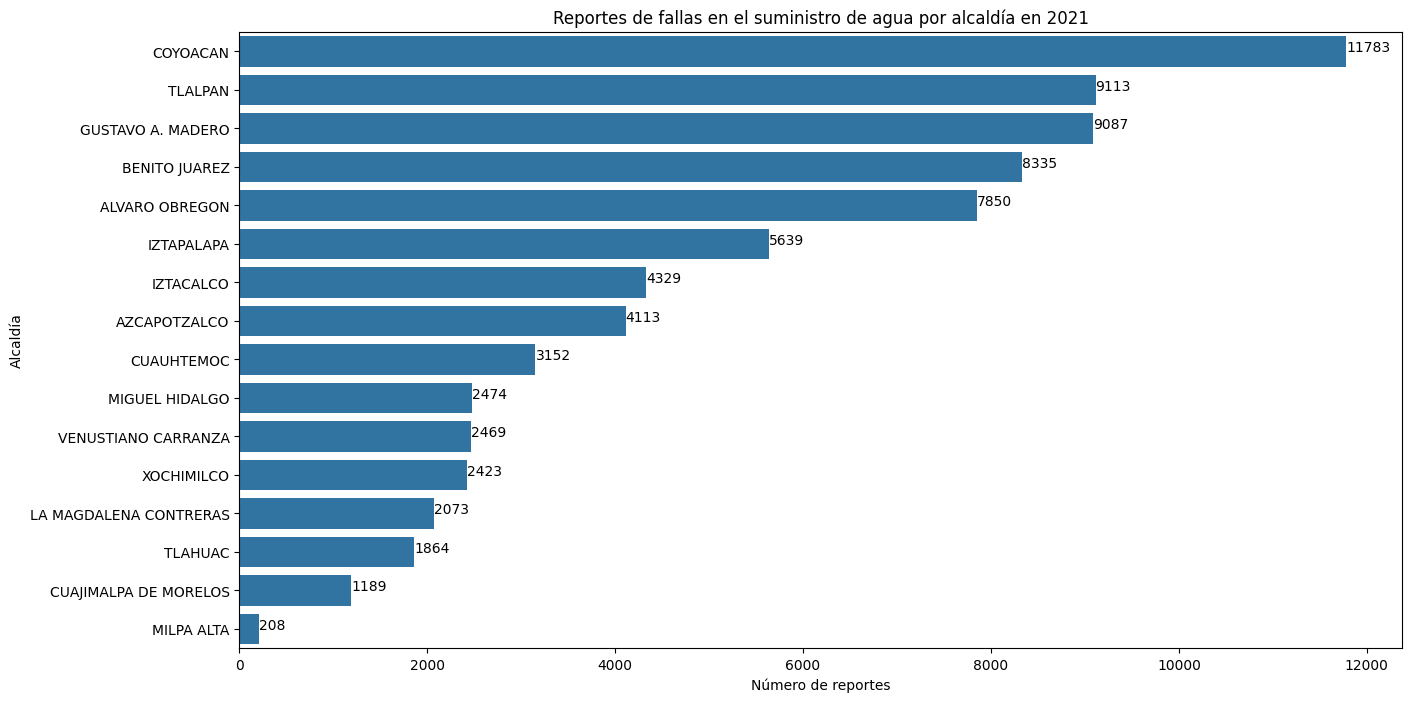

In [37]:
# Gráfica de barras de reportes por alcaldía
reportes_por_alcaldia = reportes_2021['alcaldia'].value_counts()

plt.figure(figsize=(15, 8))
sns.barplot(x=reportes_por_alcaldia.values, y=reportes_por_alcaldia.index)
#imprimir la cantidad de reportes por alcaldia en cada columna
for i, alcaldia in enumerate(reportes_por_alcaldia.index):
    plt.text(reportes_por_alcaldia.values[i], i, reportes_por_alcaldia.values[i])

plt.xlabel('Número de reportes')
plt.ylabel('Alcaldía')
plt.title('Reportes de fallas en el suministro de agua por alcaldía en 2021')
#guardar la grafica
plt.savefig('reportes_por_alcaldia.png', bbox_inches='tight')
plt.show()




 2. Grafica de las fallas en el suministro de agua (mayor que 100) por colonia de Coyoacan en 2021

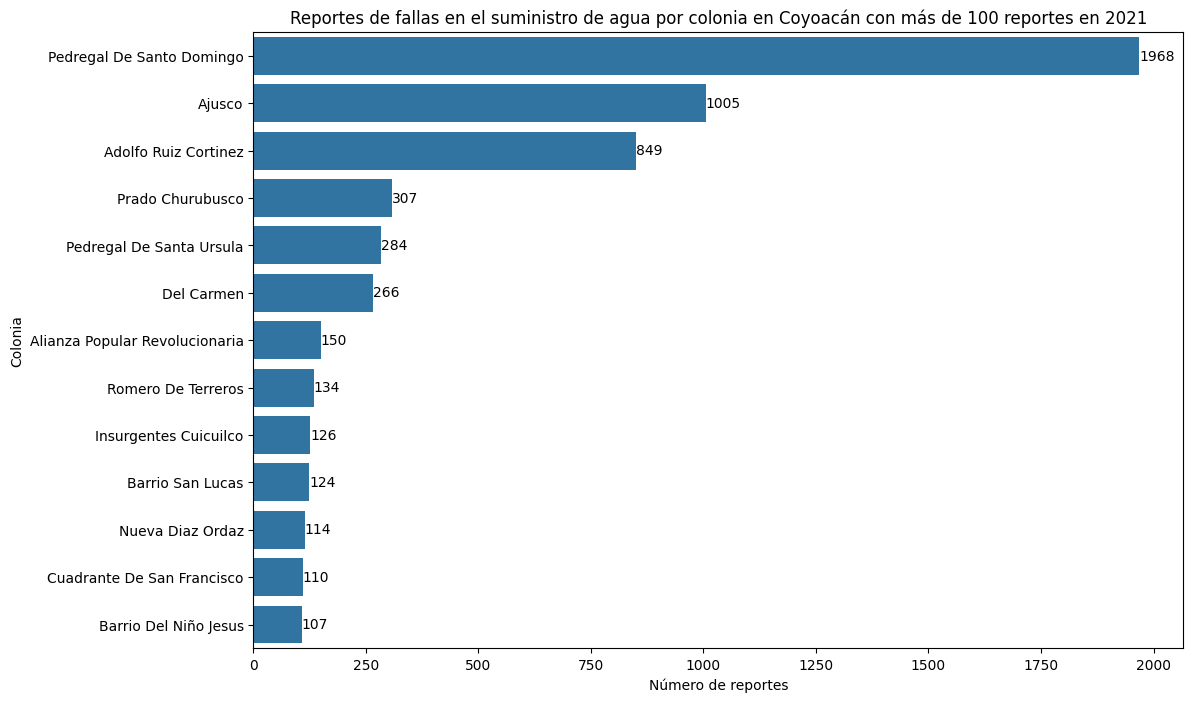

In [18]:
# Filtrar por la alcaldía de interés (si aún no está filtrado)
alcaldia_seleccionada = 'Coyoacán'
colonias_filtradas = colonias_gdf[colonias_gdf['alc'] == alcaldia_seleccionada]

# Filtrar las colonias con más de 100 reportes
colonias_filtradas = colonias_filtradas[colonias_filtradas['conteo'] > 100]

# Ordenar las colonias por el conteo de reportes
colonias_filtradas = colonias_filtradas.sort_values(by='conteo', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=colonias_filtradas['conteo'], y=colonias_filtradas['colonia'])

# Imprimir la cantidad de reportes por colonia en cada columna
for i, colonia in enumerate(colonias_filtradas['colonia']):
    plt.text(colonias_filtradas['conteo'].iloc[i], i, colonias_filtradas['conteo'].iloc[i], ha='left', va='center')

plt.xlabel('Número de reportes')
plt.ylabel('Colonia')
plt.title(f'Reportes de fallas en el suministro de agua por colonia en {alcaldia_seleccionada} con más de 100 reportes en 2021')
#gurdar la grafica 
plt.savefig('reportes_por_colonia.png', bbox_inches='tight')
plt.show()


### Datos a trabajar


In [46]:


# Suponiendo que 'reportes_2021' es tu DataFrame que contiene los reportes de 2021 y 'colonia_con_mas_reportes' es la colonia con más reportes identificada
reportes_colonia = reportes_alcaldia[reportes_alcaldia['colonia_datos_abiertos'] == colonia_con_mas_reportes]

# Crear un DataFrame con las fechas de los reportes y un contador de 1
reportes_colonia_fechas = reportes_colonia[['fecha']].copy()
reportes_colonia_fechas['count'] = 1

# Agrupar por fecha y sumar el contador
reportes_colonia_fechas = reportes_colonia_fechas.groupby('fecha').sum()

# Crear un rango de fechas con todos los días de 2021
rango_fechas = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
# Reindexar el DataFrame para incluir los días que no tienen reportes
reportes_colonia_fechas = reportes_colonia_fechas.reindex(rango_fechas, fill_value=0)

# Crear una columna con la suma acumulada de reportes
    
# guardar el dataframe
reportes_colonia_fechas


count
2021-01-01      0
2021-01-02      0
2021-01-03      0
2021-01-04      0
2021-01-05      0
...           ...
2021-12-27     12
2021-12-28      9
2021-12-29     27
2021-12-30      7
2021-12-31      2

[365 rows x 1 columns]

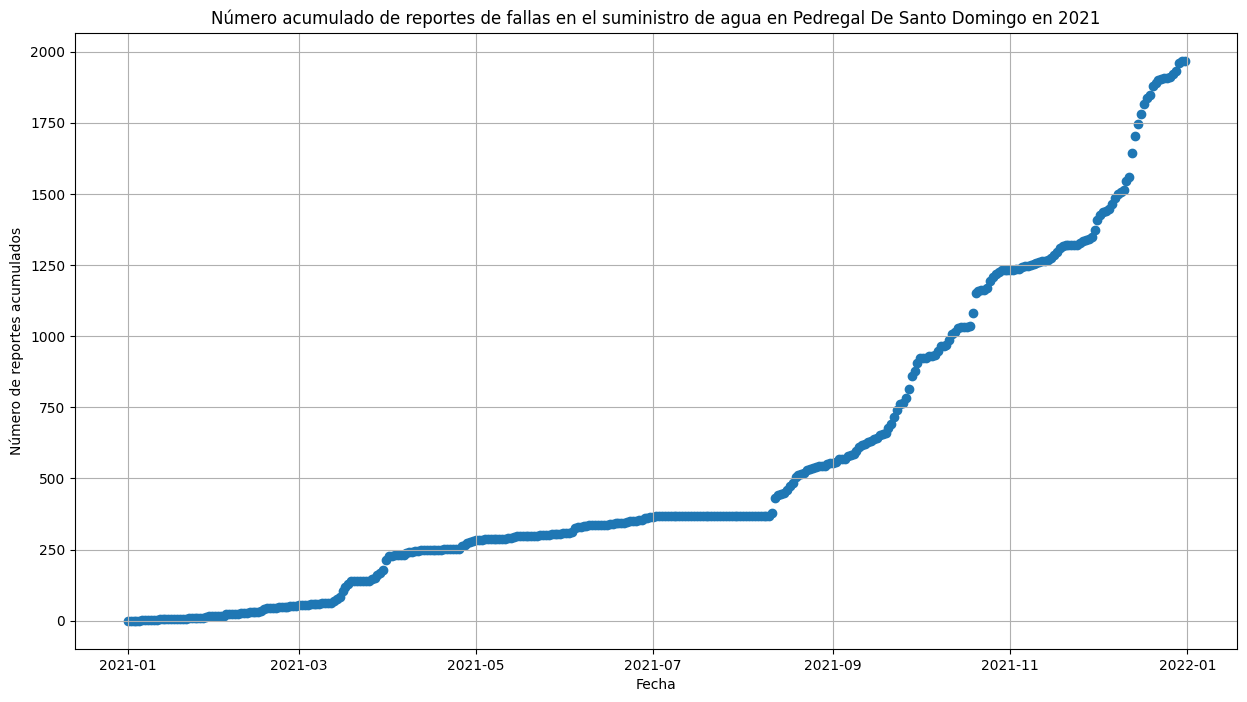

In [48]:
# Crear la gráfica de reportes por día
plt.figure(figsize=(15, 8))
plt.scatter(reportes_colonia_fechas.index, reportes_colonia_fechas['count'].cumsum(), marker='o')
plt.xlabel('Fecha')
plt.ylabel('Número de reportes acumulados')
plt.title(f'Número acumulado de reportes de fallas en el suministro de agua en {colonia_con_mas_reportes} en 2021')
plt.grid()
#plt.savefig('reportes_acumulados_colonia.png', bbox_inches='tight')
plt.show()

### Utilizar streamlit para presentar las graficas

In [16]:
import streamlit as st
import base64

st.title('Reportes de falta de agua en CDMX')
st.markdown('Este es un tablero interactivo para explorar los reportes de falta de agua en la Ciudad de México en 2021.')

# Mostrar el mapa
st.markdown('## Mapa de reportes de falta de agua en CDMX')
st.markdown('Este mapa muestra los reportes de falta de agua en la Ciudad de México en 2021.')
st.markdown('Puedes seleccionar las capas que deseas visualizar en el mapa.')

# Asegúrate de que la ruta del archivo HTML es correcta
with open('mapa.html', 'r', encoding='utf-8') as f:
    html_data = f.read()
st.components.v1.html(html_data, width=1000, height=500)

#hacer un boton con un icono de interrogacion para mostrar el audio

# Función para reproducir el audio usando JavaScript
def play_audio(audio_file):
    audio_bytes = audio_file.read()
    b64 = base64.b64encode(audio_bytes).decode()
    md = f"""
        <audio id="audio" autoplay>
            <source src="data:audio/mp3;base64,{b64}" type="audio/mp3">
        </audio>
        <script>
        document.getElementById('audio').play();
        </script>
        """
    st.markdown(md, unsafe_allow_html=True)

# Agregar CSS personalizado para posicionar el botón en la esquina inferior derecha
st.markdown(
    """
    <style>
    .fixed-button {
        position: fixed;
        bottom: 20px;
        right: 20px;
        z-index: 1000;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# Crear el botón con la clase CSS personalizada
if st.button('?', help='Haz clic para escuchar la explicacion de la falta de agua en la Ciudad de México', key='fixed-button'):
    with open('reporte_voz.mp3', 'rb') as audio_file:
        play_audio(audio_file)

    

# Mostrar la gráfica de barras de reportes por alcaldía
st.markdown('## Reportes de falta de agua por alcaldía en 2021')
st.markdown('Esta gráfica muestra el número de reportes de falta de agua por alcaldía en la Ciudad de México en 2021.')
# Asegúrate de que la ruta de la imagen es correcta
st.image('reportes_por_alcaldia.png', width=1000)

# Mostrar la gráfica de barras de reportes por colonia
st.markdown('## Reportes de falta de agua por colonia en Coyoacán en 2021')
st.markdown('Esta gráfica muestra el número de reportes de falta de agua por colonia en Coyoacán en 2021.')
# Asegúrate de que la ruta de la imagen es correcta
st.image('reportes_por_colonia.png', width=1000)


AttributeError: partially initialized module 'streamlit' has no attribute 'title' (most likely due to a circular import)